# BI - Laboratorio 1

## Integrantes
- Jose David Martinez - 202116677
- Manuel Felipe Carvajal - 202014203
- Juanita Gil - 202111556

# 0 - Imports

In [1]:
# Instalación automática de dependencias (si faltan)
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Instalar wordcloud si no está
try:
    import wordcloud
except ImportError:
    install("wordcloud")

# Instalar spaCy y el modelo de español si no están
try:
    import spacy
    from spacy.util import is_package
    if not is_package("es_core_news_sm"):
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_sm"])
except ImportError:
    install("spacy")
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "es_core_news_sm"])


# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Librerías de preprocesamiento y NLP
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Librerías de scikit-learn para modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score


# 1. Carga de Datos

In [2]:
# Cargar el dataset de opiniones
data = pd.read_excel("Datos_proyecto.xlsx")

# Revisar primeras filas
data.head()

# Información general
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


# 2. Entendimiento y preparación de datos

### 2.1 Distribución de clases

En primer lugar se analizó la distribución de clases presentes en los datos. Este análisis permite identificar cuántas opiniones corresponden a cada uno de los Objetivos de Desarrollo Sostenible considerados en el proyecto: ODS 1 (Fin de la pobreza), ODS 3 (Salud y bienestar) y ODS 4 (Educación de calidad). Los resultados evidencian la cantidad de registros por categoría y permiten observar posibles desbalances entre clases, lo cual es un factor relevante porque puede afectar el desempeño de los modelos de clasificación. Este paso inicial es fundamental para conocer la representatividad de los datos y orientar las decisiones posteriores en cuanto a técnicas de preprocesamiento y modelado.

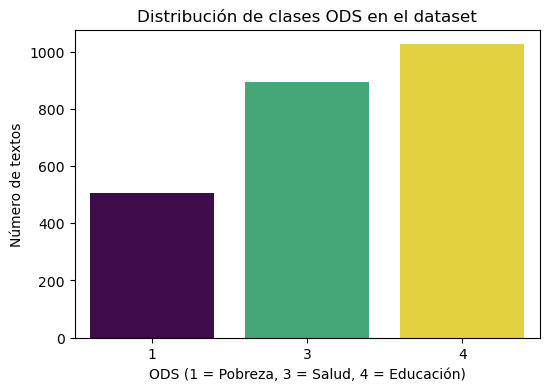

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [73]:
# Distribución de clases ODS
conteo_clases = data['labels'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=conteo_clases.index, y=conteo_clases.values,  hue=conteo_clases.index, palette="viridis", legend=False)
plt.title("Distribución de clases ODS en el dataset")
plt.xlabel("ODS (1 = Pobreza, 3 = Salud, 4 = Educación)")
plt.ylabel("Número de textos")
plt.show()

conteo_clases

### 2.2 Análisis de la longitud de los textos.

Se analizó la longitud de los textos en términos de número de palabras y de caracteres. Este análisis es importante porque permite detectar opiniones demasiado cortas que podrían no aportar información suficiente para el modelo, así como textos muy largos que podrían ser inservibles. Se calcularon estadísticas descriptivas como la media, la desviación estándar, los valores mínimos y máximos, y además se construyó un histograma para visualizar la distribución de longitudes. Los resultados obtenidos ofrecen una idea clara de la variabilidad en la extensión de los textos y constituyen una base para tomar decisiones en la etapa de preprocesamiento, como establecer umbrales mínimos de longitud para conservar las instancias útiles.

       num_palabras  num_caracteres
count   2424.000000     2424.000000
mean     107.924092      683.223185
std       35.575349      223.563695
min       41.000000      303.000000
25%       81.000000      513.000000
50%      102.000000      647.000000
75%      129.000000      809.250000
max      260.000000     1492.000000


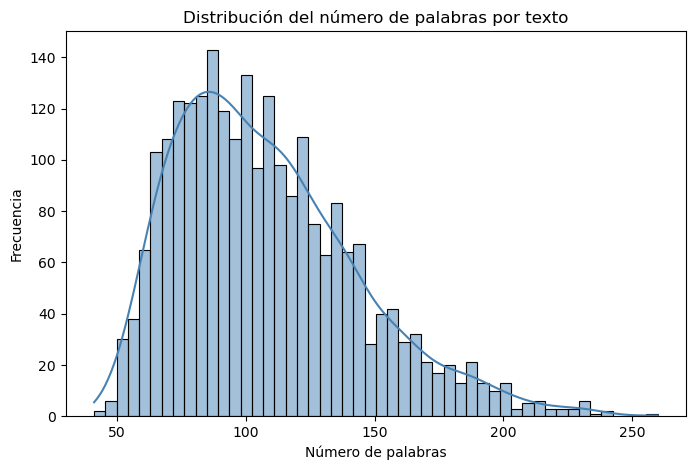

In [4]:
# Crear variables de longitud
data['num_palabras'] = data['textos'].apply(lambda x: len(str(x).split()))
data['num_caracteres'] = data['textos'].apply(lambda x: len(str(x)))

# Estadísticas descriptivas
print(data[['num_palabras','num_caracteres']].describe())

# Histograma de número de palabras
plt.figure(figsize=(8,5))
sns.histplot(data['num_palabras'], bins=50, kde=True, color="steelblue")
plt.title("Distribución del número de palabras por texto")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()


### 2.3 Detección de valores nulos y duplicados.

Se verificó la existencia de valores nulos y registros duplicados en los datos. La presencia de datos faltantes o repetidos puede comprometer la calidad del modelo y sesgar los resultados. La revisión se realizó tanto a nivel de columnas como a nivel de filas completas. De esta manera, se garantiza que los textos que ingresen al proceso de preprocesamiento y modelado sean instancias únicas y contengan información válida. En caso de encontrarse valores nulos o duplicados, se deben definir estrategias de tratamiento, como la eliminación de registros o la imputación de información, según corresponda.

In [5]:
# Verificación de valores nulos
nulos = data.isnull().sum()

# Verificación de duplicados
duplicados = data.duplicated().sum()

print("Valores nulos por columna:")
print(nulos)
print(f"\nNúmero de filas duplicadas: {duplicados}")


Valores nulos por columna:
textos            0
labels            0
num_palabras      0
num_caracteres    0
dtype: int64

Número de filas duplicadas: 0


### 2.4 Revisión de ejemplos de textos por clase.

Además de los análisis cuantitativos, se revisaron ejemplos de textos pertenecientes a cada clase con el objetivo de comprender el tipo de lenguaje y los temas asociados a los diferentes ODS. Esto permite verificar que las etiquetas asignadas corresponden de manera coherente al contenido textual, así como identificar palabras o expresiones frecuentes que podrían resultar relevantes para el proceso de clasificación. La exploración de ejemplos reales ayuda a contextualizar los datos y nos da una visión preliminar sobre las características lingüísticas que diferencian a cada categoría, lo cual será útil para diseñar las transformaciones de texto y evaluar posteriormente la interpretabilidad de los modelos.

In [6]:
# Mostrar ejemplos de textos por clase ODS
for label in sorted(data['labels'].unique()):
    print(f"\nEjemplos de ODS {label}:")
    ejemplos = data[data['labels'] == label]['textos'].sample(3, random_state=42).to_list()
    for i, texto in enumerate(ejemplos, 1):
        # limitar a 300 caracteres 
        print(f"{i}. {texto[:300]}")  



Ejemplos de ODS 1:
1. En tres (Chile, Perú y Uruguay), el efecto de este factor se vio potenciado por una mejora en la distribución, al menos en el área de distribución cercana a la línea de pobreza. Por otro lado, la tendencia a la baja de la pobreza en Argentina y República Dominicana fue, en parte, frenada —no ayudada
2. Por ejemplo, con el umbral de pobreza definido en el 60% de los ingresos medios de un país, en 2006, 72 millones de personas en la UE estaban en riesgo de caer en la pobreza, y en 2001, más de la mitad de todas las personas en hogares con bajos ingresos en la UE vivían con el riesgo persistente de c
3. Pasar de políticas comprometidas de salario mínimo a un reparto mucho más justo de las ganancias de productividad y de los beneficios debería ser un punto de partida. Ya veremos, pero sin duda de esto tratarán la política y las luchas sociales en los próximos años. La capacidad de hacer frente a los

Ejemplos de ODS 3:
1. La sobremedicación es un motivo de preocupaci

### 2.4 Perfilamiento

En esta sección se utilizará pandas_profiling para generar un informe detallado del dataset. El reporte incluirá análisis estadísticos exploratorios como la distribución de las variables, la identificación de valores nulos, la detección de posibles outliers y la evaluación de la correlación entre las variables. Esto permitirá obtener una visión aún más especifica de la calidad y estructura de los datos que a lo mejor no se alcanza a visualizar con solo gráficas tradicionales.

In [ ]:
![image.png](attachment:image.png)

In [ ]:
#from ydata_profiling import ProfileReport
# Perfilamiento de los datos a través de ydata_profiling
#df = pd.read_excel("Datos_proyecto.xlsx")
#profile = ProfileReport(df, title="EDA proyecto – Entrenamiento", explorative=True)
#vollver html para explorar mejor
#profile.to_file("eda_proyecto.html")

El conjunto de datos analizado contiene un total de 2.424 observaciones y 2 variables: una columna de texto con las opiniones ciudadanas y una columna categórica con la etiqueta que indica el ODS correspondiente. No se encontraron valores faltantes en ninguna de las columnas, lo que garantiza una completitud del 100 %. Tampoco se identificaron filas duplicadas, de manera que cada registro representa una opinión distinta.


### 2.5 Analisis de calidad


#### 2.5.1 Analisis de Completitud

Se evaluó la completitud de los datos para identificar la presencia de valores faltantes en las columnas de interés. Este análisis permite determinar si el dataset contiene vacíos que puedan afectar el proceso de aprendizaje automático. El cálculo del porcentaje de nulos mostró que tanto la columna de textos como la de etiquetas están completas, lo cual garantiza que no se requiere un tratamiento adicional de imputación o eliminación de registros por ausencia de información.

In [8]:
# Completitud: porcentaje de nulos por columna
completitud = data.isnull().mean() * 100
completitud


textos            0.0
labels            0.0
num_palabras      0.0
num_caracteres    0.0
dtype: float64

#### 2.5.2 Analisis de unicidad

La unicidad se evaluó calculando cuántos textos son distintos dentro del dataset. Este paso es clave porque la existencia de opiniones repetidas puede generar sesgos en el entrenamiento, al darle más peso a ciertos contenidos. El conteo mostró que la gran mayoría de registros son únicos.

In [9]:
num_total = len(data)
num_unicos = data['textos'].nunique()
duplicados = num_total - num_unicos
print(f"Total registros: {num_total}")
print(f"Registros únicos: {num_unicos}")
print(f"Duplicados: {duplicados}")


Total registros: 2424
Registros únicos: 2424
Duplicados: 0


#### 2.5.3 Analisis de validez

Para garantizar la validez de los datos, se revisaron los valores posibles de la columna de etiquetas. Dado que el problema se restringe a los ODS 1, 3 y 4, cualquier valor fuera de este rango representaría un error. La inspección de la variable confirmó que únicamente aparecen los valores esperados, lo cual asegura que no es necesario realizar correcciones en este aspecto.

In [10]:
valores_labels = data['labels'].unique()
print("Valores encontrados en labels:", valores_labels)


Valores encontrados en labels: [4 3 1]


#### 2.5.3 Analisis de consitencia

Finalmente, se evaluó la consistencia interna de los datos, entendida como la coherencia entre el contenido textual y su utilidad para el análisis. Se verificó que no existan opiniones vacías y se identificaron los casos en los que los textos tienen menos de tres palabras, ya que en estos casos la información es insuficiente para que el modelo aprenda patrones significativos. Este tipo de registros serán revisados y posiblemente descartados en la fase de limpieza, con el fin de mantener la integridad del corpus y garantizar resultados confiables.

In [11]:
textos_vacios = data[data['textos'].str.strip().eq("")].shape[0]

# Textos con menos de 3 palabras
textos_cortos = data[data['num_palabras'] < 3].shape[0]

print("Textos vacíos:", textos_vacios)
print("Textos muy cortos (<3 palabras):", textos_cortos)


Textos vacíos: 0
Textos muy cortos (<3 palabras): 0


# 3. Preparación de los Datos

#### 3.1 Normalización

Como primer paso de la preparación se aplicó una normalización básica al texto. Esta consistió en pasar todo el contenido a minúsculas, eliminar acentos, URLs, números y signos de puntuación, además de unificar espacios. El objetivo de estas transformaciones es reducir el ruido en los datos y garantizar que expresiones equivalentes, como “Educación” y “educacion”, sean tratadas de la misma manera por el modelo.

In [12]:
import re, unidecode
import pandas as pd

def normalizar(texto: str) -> str:
    t = str(texto)
    t = t.lower()
    t = unidecode.unidecode(t)
    t = re.sub(r"http\S+|www\S+|https\S+", " ", t)      # URLs
    t = re.sub(r"\S+@\S+", " ", t)                      # correos
    t = re.sub(r"@\w+|#\w+", " ", t)                    # @menciones y hashtags
    t = re.sub(r"\d+", " ", t)                          # números
    t = re.sub(r"[^\w\s]", " ", t)                      # signos y símbolos
    t = re.sub(r"\s+", " ", t).strip()                  # espacios múltiples
    return t

data = data.copy()  
data["texto_norm"] = data["textos"].apply(normalizar)


ej_norm = data.sample(5, random_state=7)[["textos", "texto_norm"]]
ej_norm


,textos,texto_norm
1355,"Además, la Escuela de Educación a Distancia de...",ademas la escuela de educacion a distancia de ...
1770,Esto puede conducir a un bajo uso de la capaci...,esto puede conducir a un bajo uso de la capaci...
240,Se han realizado varios esfuerzos para hacer f...,se han realizado varios esfuerzos para hacer f...
1604,Más de la mitad de los estudiantes nacionales ...,mas de la mitad de los estudiantes nacionales ...
1871,El cuarto enfoque añadía a las sesiones de for...,el cuarto enfoque anadia a las sesiones de for...


#### 3.2 Tokenización y stopwords

Posteriormente, se realizó la tokenización de cada opinión en palabras y se eliminaron las stopwords en español, es decir, aquellas palabras muy frecuentes que no aportan significado discriminativo al modelo, como “que”, “de”, “el” o “pero”. Esta reducción mejora la representatividad de las características relevantes para diferenciar entre las categorías ODS

In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)

stop_es = set(stopwords.words("spanish"))

def quitar_stopwords(texto: str) -> str:
    toks = texto.split()
    toks = [t for t in toks if t not in stop_es]
    return " ".join(toks)

data["texto_sws"] = data["texto_norm"].apply(quitar_stopwords)

ej_sws = data.sample(5, random_state=11)[["texto_norm", "texto_sws"]]
ej_sws


,texto_norm,texto_sws
1245,los estudios sobre la aceptacion de los benefi...,estudios aceptacion beneficios encuentran regu...
1349,por lo tanto las lineas de pobreza son diferen...,lineas pobreza diferentes paises largo tiempo ...
2168,hasta la fecha se reconoce ampliamente que el ...,fecha reconoce ampliamente sistema atencion sa...
1745,hay muchos profesores no cualificados en las e...,profesores cualificados escuelas dificil contr...
1333,estos resultados son logrados por maestros y l...,resultados logrados maestros lideres escolares...


#### 3.3 Lematización

Con el fin de homogenizar las palabras a su forma base, se aplicó lematización utilizando el modelo de spaCy en español. Gracias a esta técnica, diferentes variaciones de una misma palabra, como “aprendiendo” y “aprendí”, se reducen a la raíz “aprender”, lo cual favorece la capacidad del modelo para identificar patrones semánticos.

In [14]:
import importlib.util

def tiene_paquete(nombre):
    return importlib.util.find_spec(nombre) is not None

usa_spacy = tiene_paquete("spacy")

if usa_spacy:
    import spacy
    from spacy.util import is_package
    if not is_package("es_core_news_sm"):
        print("El modelo 'es_core_news_sm' no está instalado. Instálalo con:")
        print("    python -m spacy download es_core_news_sm")
        usa_spacy = False

if usa_spacy:
    nlp = spacy.load("es_core_news_sm", disable=["ner"])
    def lematizar(texto: str) -> str:
        doc = nlp(texto)
        return " ".join(t.lemma_ for t in doc if t.lemma_)
    
    data["texto_lemmas"] = [" ".join(t.lemma_ for t in doc if t.lemma_) 
                            for doc in nlp.pipe(data["texto_sws"], batch_size=1000)]
else:
    
    import nltk
    from nltk.stem import SnowballStemmer
    nltk.download("punkt", quiet=True)
    stemmer = SnowballStemmer("spanish")
    def lematizar(texto: str) -> str:
        return " ".join(stemmer.stem(t) for t in texto.split())
    data["texto_lemmas"] = data["texto_sws"].apply(lematizar)

ej_lem = data.sample(5, random_state=23)[["texto_sws", "texto_lemmas"]]
ej_lem


,texto_sws,texto_lemmas
58,medidas sector salud incluyeron reduccion sala...,medida sector salud incluir reduccion salario ...
1139,ademas posible centros compartan mismo kit dis...,adema posible centro compartar mismo kit disti...
2259,planteamientos sido asumidos plenamente cepal ...,planteamiento ser asumir plenamente cepal decl...
211,descubrio enfermedad virus ebola brote demostr...,descubrio enfermedad virus ebola brote demostr...
855,puede decir realmente tasa pobreza infantil au...,poder decir realmente tasa pobreza infantil au...


#### 3.4 Representación vectorial

Finalmente, los textos procesados se transformaron en representaciones numéricas mediante TF-IDF, una técnica que asigna un peso a cada palabra en función de su frecuencia en el documento y en el corpus total. Para capturar expresiones compuestas se consideraron unigramas y bigramas, y se limitó el vocabulario a un máximo de veinte mil términos con el fin de controlar la dimensionalidad.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizador = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X = vectorizador.fit_transform(data['texto_lemmas'])
y = data['labels']

X.shape


(2424, 20000)

### 3.5 Resumen comparativo 

In [16]:
cols_show = ["textos", "texto_norm", "texto_sws", "texto_lemmas", "labels"]
comparativa = data.sample(8, random_state=33)[cols_show]
comparativa


,textos,texto_norm,texto_sws,texto_lemmas,labels
592,Las reformas de descentralización educativa ge...,las reformas de descentralizacion educativa ge...,reformas descentralizacion educativa generalme...,reforma descentralizacion educativo generalmen...,4
339,La financiación a corto plazo puede crear una ...,la financiacion a corto plazo puede crear una ...,financiacion corto plazo puede crear brecha ex...,financiacion corto plazo poder crear brecha ex...,1
2058,Reformas recomendadas al sistema de salud de M...,reformas recomendadas al sistema de salud de m...,reformas recomendadas sistema salud mexico con...,reforma recomendado sistema salud mexico cont ...,3
841,"A modo de comparación, la brecha en el dominio...",a modo de comparacion la brecha en el dominio ...,modo comparacion brecha dominio alfabetizacion...,modo comparacion brecho dominio alfabetizacion...,4
1924,"En 2008, la OCDE/IMHE lanzó una segunda serie ...",en la ocde imhe lanzo una segunda serie de rev...,ocde imhe lanzo segunda serie revisiones ocde ...,ocde imhe lanzar segundo serie revisión ocde e...,4
1766,Costa Rica puede aprovechar sus muchas fortale...,costa rica puede aprovechar sus muchas fortale...,costa rica puede aprovechar muchas fortalezas ...,costa rico poder aprovechar mucho fortaleza in...,4
2011,"En Noruega, esto puede explicarse por un tiemp...",en noruega esto puede explicarse por un tiempo...,noruega puede explicarse tiempo superior prome...,noruegar poder explicar él tiempo superior pro...,4
234,Esto podría llevarse a cabo como una investiga...,esto podria llevarse a cabo como una investiga...,podria llevarse cabo investigacion accion prop...,podrio llevar él cabo investigacion accion pro...,4


### 3.6 Efecto de las transformaciones en el tamaño del vocabulario y la longitud promedio

Se cuantificó el efecto de las transformaciones sobre el vocabulario y la longitud promedio de los textos. El tamaño del vocabulario disminuye  después de eliminar stopwords y aplicar lematización. Asimismo, la longitud media en palabras se reduce, reflejando la eliminación de términos no informativos y la consolidación morfológica. Estos cambios son deseables para facilitar la vectorización y mejorar la eficiencia del modelado sin perder señales semánticas clave.

In [17]:
def tam_vocab(serie):
    vocab = set()
    for s in serie:
        vocab.update(s.split())
    return len(vocab)

vocab_norm = tam_vocab(data["texto_norm"])
vocab_sws  = tam_vocab(data["texto_sws"])
vocab_lem  = tam_vocab(data["texto_lemmas"])

long_prom_ori = data["textos"].apply(lambda s: len(str(s).split())).mean()
long_prom_lem = data["texto_lemmas"].apply(lambda s: len(str(s).split())).mean()

print(f"Tamaño de vocabulario tras normalización: {vocab_norm}")
print(f"Tamaño de vocabulario tras quitar stopwords: {vocab_sws}")
print(f"Tamaño de vocabulario tras lematización/stemming: {vocab_lem}")
print(f"Longitud promedio original (palabras): {long_prom_ori:.2f}")
print(f"Longitud promedio final (palabras): {long_prom_lem:.2f}")


Tamaño de vocabulario tras normalización: 14061
Tamaño de vocabulario tras quitar stopwords: 13928
Tamaño de vocabulario tras lematización/stemming: 10785
Longitud promedio original (palabras): 107.92
Longitud promedio final (palabras): 56.34


### 3.7 Datos finales

Finalmente, se consolidó un conjunto de datos preparado con la columna de texto transformado y la etiqueta correspondiente, el cual se guarda en disco para ser utilizado en la fase de vectorización y entrenamiento de modelos.

In [18]:
data_prep = data[["texto_lemmas", "labels"]].rename(columns={"texto_lemmas": "texto"})
data_prep.to_csv("datos_proyecto_preparados.csv", index=False)
len(data_prep), data_prep.head(3)


(2424,
                                                texto  labels
 0  aprendizaje educacion considerar sinonimo esco...       4
 1  nino mas pequeno beb nino pequeno capacitacion...       4
 2  adema formacion especialista medicín general t...       3)

# 4. Modelado y evaluación

### 4.1 Train/test

Para evaluar el desempeño de los modelos de manera objetiva se dividió el conjunto de datos en entrenamiento y prueba mediante una partición estratificada. La estratificación garantiza que la proporción de clases en ambos subconjuntos sea similar a la del dataset original, lo cual es especialmente importante cuando existe desbalance entre las etiquetas. Esta separación evita fugas de información y permite estimar la capacidad de generalización del clasificador sobre ejemplos no vistos durante el entrenamiento.

In [19]:
import pandas as pd

if 'data_prep' in globals():
    df_model = data_prep.copy() 
elif 'data' in globals() and 'texto_lemmas' in data.columns:
    df_model = data[['texto_lemmas', 'labels']].rename(columns={'texto_lemmas': 'texto'}).copy()
else:
    raise ValueError("No se encontró data_prep['texto'] ni data['texto_lemmas'].")


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_model['texto'],
    df_model['labels'],
    test_size=0.20,
    random_state=42,
    stratify=df_model['labels']
)

len(X_train), len(X_test), y_train.value_counts(normalize=True).sort_index(), y_test.value_counts(normalize=True).sort_index()


(1939,
 485,
 labels
 1    0.208355
 3    0.368747
 4    0.422898
 Name: proportion, dtype: float64,
 labels
 1    0.208247
 3    0.369072
 4    0.422680
 Name: proportion, dtype: float64)

### 4.2 MODELO #1 - Regresión Logística

Como línea base se entrenó un pipeline compuesto por TF-IDF y Regresión Logística multinomial. La representación TF-IDF pondera los términos en función de su frecuencia relativa y se configuró con unigramas y bigramas para capturar expresiones compuestas. La Regresión Logística, con regularización y el solver saga, es una elección robusta para espacios de alta dimensionalidad típicos de la clasificación de textos. Se activó class_weight balanced para mitigar el desbalance entre ODS y se reportan métricas estándar de clasificación, incluyendo el f1-macro, que pondera por igual el desempeño en cada clase.

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),        
        max_features=20000,        
        sublinear_tf=True,         
        min_df=2,                  
        max_df=0.9                 
    )),
    ("clf", LogisticRegression(
        solver="saga",             
        max_iter=2000,
        n_jobs=-1,
        class_weight="balanced",   
        C=1.0                      
    ))
])

pipe_lr.fit(X_train, y_train)


from sklearn.metrics import classification_report, f1_score, confusion_matrix

y_pred = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print("F1 macro:", f1_score(y_test, y_pred, average="macro"))


              precision    recall  f1-score   support

           1      0.960     0.960     0.960       101
           3      0.966     0.961     0.964       179
           4      0.971     0.976     0.973       205

    accuracy                          0.967       485
   macro avg      0.966     0.966     0.966       485
weighted avg      0.967     0.967     0.967       485

F1 macro: 0.9657391611699967


#### 4.2.1 Matriz de confusión - Regresión logistíca

La matriz de confusión permite visualizar con claridad los aciertos y errores por clase, identificando de forma directa en qué etiquetas el modelo confunde con mayor frecuencia las predicciones. Este insumo es útil para decidir ajustes posteriores, como refinar la limpieza de texto, modificar el espacio de n-gramas, ajustar la regularización o explorar umbrales y técnicas de balanceo más específicas.

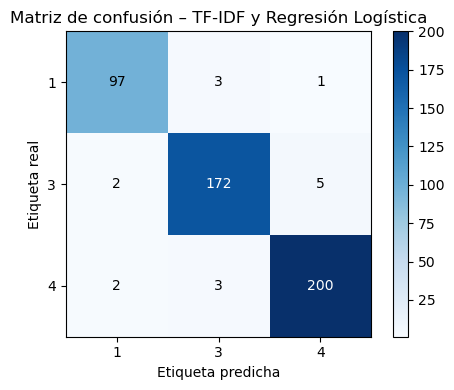

In [21]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred, labels=sorted(y_train.unique()))
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(cm)),
    yticks=np.arange(len(cm)),
    xticklabels=sorted(y_train.unique()),
    yticklabels=sorted(y_train.unique()),
    ylabel='Etiqueta real',
    xlabel='Etiqueta predicha',
    title='Matriz de confusión – TF-IDF y Regresión Logística'
)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")


thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()



ODS 1 (pobreza): 97 aciertos, solo 4 errores.

ODS 3 (salud): 172 aciertos, 7 errores.

ODS 4 (educación): 200 aciertos, 5 errores repartidos entre ODS 1 y 3.

### 4.3 MODELO #2 - Bayes

El segundo modelo implementado fue Naïve Bayes Multinomial, un algoritmo ampliamente utilizado en clasificación de textos debido a su simplicidad y eficiencia. Este clasificador asume independencia condicional entre las características, lo que lo hace rápido en entrenamiento y predicción. A pesar de sus supuestos restrictivos, suele ofrecer resultados competitivos como baseline en problemas de clasificación multiclase

In [22]:
from sklearn.naive_bayes import MultinomialNB

pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_features=20000,
        sublinear_tf=True,
        min_df=2,
        max_df=0.9
    )),
    ("clf", MultinomialNB())
])

pipe_nb.fit(X_train, y_train)
y_pred_nb = pipe_nb.predict(X_test)

print(classification_report(y_test, y_pred_nb, digits=3))
print("F1 macro:", f1_score(y_test, y_pred_nb, average="macro"))


              precision    recall  f1-score   support

           1      0.987     0.733     0.841       101
           3      0.923     0.939     0.931       179
           4      0.899     1.000     0.947       205

    accuracy                          0.922       485
   macro avg      0.936     0.890     0.906       485
weighted avg      0.926     0.922     0.919       485

F1 macro: 0.9061797434789444


#### 4.3.1 Matriz de confusión - Bayes

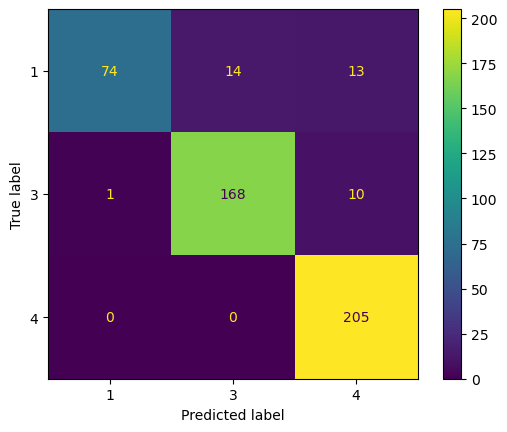

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm_nb = confusion_matrix(y_test, y_pred_nb, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=sorted(y_train.unique())).plot()


ODS 1 (pobreza): 74 aciertos, 27 errores ,14 confundidos con ODS 3 y 13 con ODS 4. 

ODS 3 (salud): 168 aciertos, 11 errores.

ODS 4 (educación): 205 aciertos, ningún error.

### 4.4 MODELO #3 - SVM lineal

Como tercer enfoque se empleó un clasificador lineal entrenado mediante SGDClassifier con función de pérdida hinge, equivalente a una Máquina de Vectores de Soporte lineal. Este modelo es adecuado para espacios de alta dimensionalidad y aprovecha el entrenamiento incremental basado en descenso estocástico de gradiente, lo que permite manejar corpora de gran tamaño con eficiencia. Al igual que en la regresión logística, se utilizó un esquema de ponderación de clases para mitigar el desbalance.

In [24]:
from sklearn.linear_model import SGDClassifier

pipe_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_features=20000,
        sublinear_tf=True,
        min_df=2,
        max_df=0.9
    )),
    ("clf", SGDClassifier(
        loss="hinge",           # hinge = SVM lineal
        penalty="l2",
        max_iter=2000,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

pipe_svm.fit(X_train, y_train)
y_pred_svm = pipe_svm.predict(X_test)

print(classification_report(y_test, y_pred_svm, digits=3))
print("F1 macro:", f1_score(y_test, y_pred_svm, average="macro"))


              precision    recall  f1-score   support

           1      0.961     0.970     0.966       101
           3      0.967     0.983     0.975       179
           4      0.995     0.976     0.985       205

    accuracy                          0.977       485
   macro avg      0.974     0.976     0.975       485
weighted avg      0.978     0.977     0.977       485

F1 macro: 0.9752693894445734


#### 4.4.1 Matriz de confusion SVM

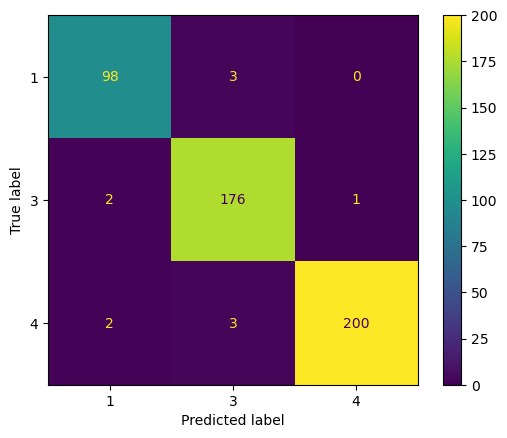

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=sorted(y_train.unique())).plot()


ODS 1 (pobreza): 98 aciertos, 3 errores.

ODS 3 (salud): 176 aciertos, 3 errores

ODS 4 (educación): 200 aciertos, 5 errores repartidos entre ODS 1 y 3.

# 5. Resultados

En esta sección se presentan los hallazgos del modelado, incluyendo la comparación del desempeño entre los diferentes algoritmos probados y el análisis de interpretabilidad de las predicciones.

## 5.1 Comparativa entre modelos  y selección final

La tabla resume el desempeño de los tres algoritmos principales en términos de la métrica f1-macro, que pondera de manera equitativa las clases y resulta especialmente adecuada en escenarios de desbalance. Este comparativo permite identificar el modelo más prometedor para el proyecto, justificando su selección no solo por la magnitud del puntaje alcanzado, sino también por la estabilidad y la interpretabilidad que ofrece cada técnica.

In [52]:
import pandas as pd

# Calcular f1-macro de cada modelo
scores = {
    "Modelo": ["Logistic Regression", "Naïve Bayes Multinomial", "SVM lineal (SGD)"],
    "F1 macro": [
        f1_score(y_test, y_pred, average="macro"),
        f1_score(y_test, y_pred_nb, average="macro"),
        f1_score(y_test, y_pred_svm, average="macro")
    ]
}

df_scores = pd.DataFrame(scores)
df_scores

,Modelo,F1 macro
0,Logistic Regression,0.965739
1,Naïve Bayes Multinomial,0.906180
2,SVM lineal (SGD),0.975269


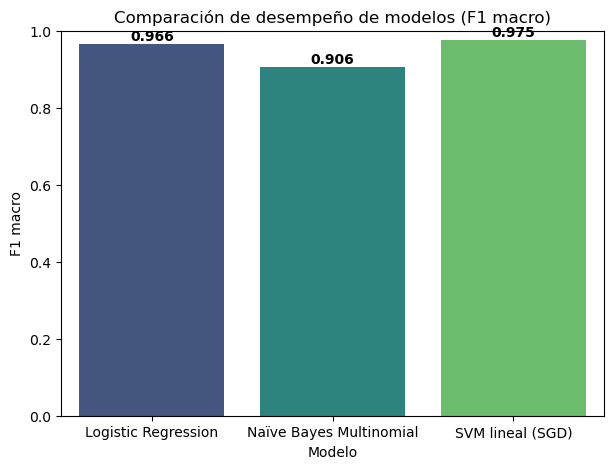

In [71]:
plt.figure(figsize=(7,5))
sns.barplot(x="Modelo", y="F1 macro", hue="Modelo", data=df_scores, palette="viridis", legend=False)
plt.title("Comparación de desempeño de modelos (F1 macro)")
plt.ylabel("F1 macro")
plt.ylim(0, 1)  # escala de 0 a 1
for i, v in enumerate(df_scores["F1 macro"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontweight="bold")
plt.show()

La comparación de los tres modelos entrenados bajo el esquema TF-IDF muestra diferencias claras en su desempeño global. El modelo de Naïve Bayes Multinomial alcanzó un f1-macro de aproximadamente 0.91. Aunque constituye un buen punto de partida por su simplicidad y rapidez, presentó mayores errores en la clasificación de textos asociados al ODS 1 (pobreza), lo cual limita su utilidad práctica para este proyecto.

Por su parte, la Regresión Logística logró un f1-macro de 0.966, evidenciando un balance mucho más sólido entre precisión y recall en todas las clases. Sus resultados son consistentes en la mayoría de categorías, lo que la convierte en un modelo robusto e interpretable, con un buen potencial de despliegue.

Finalmente, el modelo de SVM lineal (SGDClassifier) obtuvo el mejor rendimiento, alcanzando un f1-macro de 0.975. Además de superar ligeramente a la Regresión Logística en la métrica global, su matriz de confusión mostró un número mínimo de errores en todas las clases, lo que confirma una capacidad de generalización superior.

En conclusión, aunque tanto Naïve Bayes como Regresión Logística ofrecen desempeños competitivos, el SVM lineal fue seleccionado como modelo final por combinar el puntaje más alto con mayor estabilidad y bajo nivel de confusiones entre categorías. Esta elección garantiza un clasificador confiable para la tarea de identificar opiniones en torno a los ODS priorizados, aportando así una herramienta sólida para el análisis de percepciones ciudadanas y la toma de decisiones estratégicas de la organización.

El modelo final (SVM lineal con TF-IDF) fue entrenado y guardado como archivo best_model.joblib en la carpeta models/ para ser reutilizado en la generación de predicciones.

In [54]:
import os
from joblib import dump

# Crear carpeta si no existe
os.makedirs("models", exist_ok=True)

# Guardar el pipeline final (asegúrate de que pipe_svm exista en memoria)
dump(pipe_svm, os.path.join("models", "best_model.joblib"))

print("Modelo guardado en: models/best_model.joblib")

Modelo guardado en: models/best_model.joblib


## 5.2 Palabras más relevantes por clase (ODS)

Se analizaron los coeficientes del modelo de Regresión Logística entrenado con TF-IDF, los cuales permiten identificar qué términos tienen mayor peso en la asignación de un texto a cada categoría. Para cada ODS se extrajeron las diez palabras más asociadas y las menos asociadas.

In [41]:
# Extraer vectorizador y modelo desde el pipeline entrenado
vectorizador = pipe_lr.named_steps["tfidf"]
modelo = pipe_lr.named_steps["clf"]

# Vocabulario
feature_names = vectorizador.get_feature_names_out()

# Obtener top palabras por clase
import numpy as np
import pandas as pd

def top_palabras_por_clase(modelo, feature_names, clase, top_n=10):
    coefs = modelo.coef_[clase]
    top_pos = np.argsort(coefs)[-top_n:][::-1]
    top_neg = np.argsort(coefs)[:top_n]
    return pd.DataFrame({
        "Palabra más asociada": feature_names[top_pos],
        "Coeficiente (+)": coefs[top_pos].round(3),
        "Palabra menos asociada": feature_names[top_neg],
        "Coeficiente (-)": coefs[top_neg].round(3)
    })

for i, clase in enumerate(modelo.classes_):
    print(f"\nODS {clase} – palabras más relevantes:")
    display(top_palabras_por_clase(modelo, feature_names, i, top_n=10))


ODS 1 – palabras más relevantes:


,Palabra más asociada,Coeficiente (+),Palabra menos asociada,Coeficiente (-)
0,pobreza,6.168,salud,-1.820
1,pobre,3.377,escuela,-1.590
2,pobrezar,2.474,atencion,-1.370
3,ingreso,2.453,ocde,-1.225
4,hogar,2.441,educacion,-1.206
5,social,1.742,enfermedad,-1.085
6,privacion,1.529,educativo,-1.075
7,proteccion social,1.425,medico,-1.020
8,proteccion,1.278,docente,-1.017
9,nino,1.191,aprendizaje,-1.012



ODS 3 – palabras más relevantes:


,Palabra más asociada,Coeficiente (+),Palabra menos asociada,Coeficiente (-)
0,salud,4.511,pobreza,-3.252
1,atencion,2.900,educacion,-2.423
2,medico,2.337,escuela,-1.987
3,paciente,2.321,pobre,-1.810
4,enfermedad,2.224,escolar,-1.410
5,sanitario,2.052,docente,-1.372
6,mental,1.603,educativo,-1.369
7,tratamiento,1.470,pobrezar,-1.341
8,hospital,1.406,nino,-1.296
9,servicio,1.405,aprendizaje,-1.274



ODS 4 – palabras más relevantes:


,Palabra más asociada,Coeficiente (+),Palabra menos asociada,Coeficiente (-)
0,educacion,3.629,pobreza,-2.915
1,escuela,3.577,salud,-2.690
2,educativo,2.444,pobre,-1.567
3,docente,2.389,atencion,-1.531
4,aprendizaje,2.286,ingreso,-1.391
5,estudiant,2.233,paciente,-1.319
6,escolar,2.129,medico,-1.317
7,alumno,1.999,hogar,-1.252
8,estudiante,1.846,persona,-1.179
9,profesor,1.599,enfermedad,-1.139


El análisis de coeficientes de la Regresión Logística permite observar con claridad los términos que el modelo considera más representativos de cada categoría. Para el ODS 1 (Fin de la pobreza), destacan palabras como pobreza, pobre, ingreso, hogar, social y protección social. Estas expresiones reflejan la relación directa entre los discursos ciudadanos y problemáticas de inequidad, condiciones de vida y programas de apoyo. La asociación de estos términos valida que el modelo identifica correctamente el vocabulario vinculado a la temática de pobreza.

En el caso del ODS 3 (Salud y bienestar), emergen con fuerza palabras como salud, atención, médico, paciente, enfermedad, hospital y tratamiento. Este conjunto de términos muestra cómo el modelo reconoce la centralidad de los servicios de salud, las enfermedades y la atención médica como ejes principales en las opiniones ciudadanas. La predominancia de este vocabulario es coherente con las preocupaciones sociales sobre acceso y calidad en los sistemas sanitarios.

Para el ODS 4 (Educación de calidad), las palabras más relevantes son educación, escuela, educativo, docente, aprendizaje, estudiante y profesor. Este conjunto está directamente alineado con el dominio semántico de la educación y confirma que el modelo logra capturar de manera precisa las nociones fundamentales en las percepciones sobre este objetivo de desarrollo.

En términos prácticos, este análisis de palabras aporta un insumo de alto valor para la organización. Identificar qué vocabulario caracteriza cada categoría permite no solo validar el desempeño del modelo, sino también diseñar estrategias de comunicación e intervención específicas. Por ejemplo, reforzar programas de protección social en el ámbito de pobreza, priorizar recursos en hospitales y atención sanitaria en salud, o fortalecer políticas relacionadas con docentes y aprendizaje en educación. De esta manera, los resultados del modelo se convierten en evidencia útil para orientar decisiones estratégicas alineadas con las necesidades ciudadanas.

## 5.3 Nubes de palabras diferenciadas por ODS

Para ofrecer una visualización intuitiva de los resultados, se generaron nubes de palabras por clase a partir de los coeficientes positivos del modelo. En cada nube, el tamaño de la palabra corresponde a la importancia relativa para clasificar un texto dentro de un ODS específico.

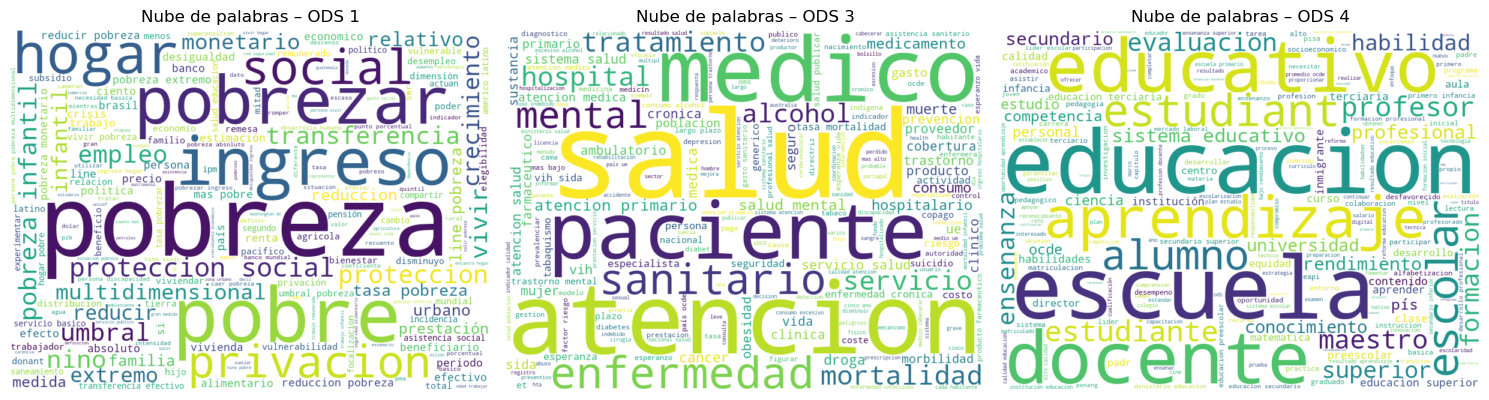

In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

classes = modelo.classes_

def frecuencias_por_clase(idx_clase, top_k=200):
    coefs = modelo.coef_[idx_clase]
    pos_idx = np.where(coefs > 0)[0]
    pos_idx_sorted = pos_idx[np.argsort(coefs[pos_idx])[::-1]][:top_k]
    return {feature_names[i]: float(coefs[i]) for i in pos_idx_sorted}

fig, axes = plt.subplots(1, len(classes), figsize=(5*len(classes), 4))
if len(classes) == 1:
    axes = [axes]

for ax, (i, label) in zip(axes, enumerate(classes)):
    freqs = frecuencias_por_clase(i, top_k=200)
    wc = WordCloud(width=800, height=600, background_color="white")
    wc.generate_from_frequencies(freqs)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Nube de palabras – ODS {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

En el caso del ODS 1 (Fin de la pobreza), la nube resalta en primer plano términos como pobreza, pobre, ingreso, hogar y protección social. Esto refleja que las opiniones relacionadas con este objetivo se centran en condiciones de vida, acceso a recursos y políticas de apoyo económico.

Para el ODS 3 (Salud y bienestar), predominan palabras como salud, paciente, atención, médico, enfermedad y hospital. Este vocabulario evidencia que la ciudadanía vincula la categoría de salud con la calidad y disponibilidad de los servicios médicos, así como con la atención a enfermedades y tratamientos.

En el ODS 4 (Educación de calidad) se destacan términos como educación, escuela, docente, aprendizaje y estudiante. La nube refleja un campo semántico directamente ligado a los procesos formativos, la infraestructura escolar y la interacción entre docentes y alumnos.

Estas visualizaciones son útiles porque permiten a la organización comunicar de manera intuitiva y accesible los hallazgos del modelo. Además, brindan insumos estratégicos: por ejemplo, reforzar programas de protección social en el ámbito de pobreza, invertir en infraestructura hospitalaria en el ámbito de salud, o fortalecer la capacitación de docentes y el acceso de estudiantes en el ámbito educativo. En conjunto, las nubes de palabras no solo validan el buen desempeño del modelo, sino que también constituyen una herramienta de apoyo a la toma de decisiones orientadas a los ODS priorizados.

## 5.4 Predicciones en datos de prueba

Se aplicó el modelo final seleccionado (SVM lineal con representación TF-IDF) al archivo de datos de prueba. Este conjunto de datos, contenía únicamente una columna con los textos en español. Se generó una nueva columna llamada label_pred con las etiquetas asignadas por el modelo, y el resultado se exportó en formato Excel.

In [61]:
import pandas as pd
from joblib import load

# 1. Cargar datos de prueba
df_prueba = pd.read_excel("Datos_proyecto.xlsx")

# 2. Cargar modelo final entrenado (si no está en memoria)
pipe_svm = load("models/best_model.joblib")

# 3. Generar predicciones
df_prueba["label_pred"] = pipe_svm.predict(df_prueba["textos"])

# 4. Guardar resultados en un archivo Excel
out_path = "predicciones_test_svm.xlsx"
df_prueba.to_excel(out_path, index=False)

df_prueba.head()

,textos,labels,label_pred
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,4
1,Para los niños más pequeños (bebés y niños peq...,4,4
2,"Además, la formación de especialistas en medic...",3,3
3,En los países de la OCDE se tiende a pasar de ...,4,4
4,Este grupo se centró en las personas que padec...,3,3
